In [216]:
import tensorflow as tf
import keras
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
from IPython.display import SVG, display
import re, os
from string import printable
import nltk
import string
from string import punctuation
import pandas as pd
from nltk.corpus import stopwords
from sklearn.manifold import TSNE
from sklearn.utils import shuffle
from sklearn import model_selection
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
from pathlib import Path
import json
from tensorflow.python.client import device_lib
from PIL import Image
import copy

## Plotly
import plotly.offline as py
import plotly.graph_objs as go

# NLTK
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

py.init_notebook_mode(connected=True)

# For reproducibility
np.random.seed(123)

In [217]:
from keras.models import  Sequential, Model, model_from_json, load_model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras import regularizers
from keras import backend as K
from keras.preprocessing import sequence
from keras.layers.core import Dense, Dropout, Activation, Lambda,Flatten, Reshape
from keras.optimizers import SGD, Adam, RMSprop
from keras.utils import np_utils
from keras.regularizers import l2
from keras.layers import Input, ELU, LSTM, Embedding, Convolution2D, MaxPooling2D, BatchNormalization, Convolution1D, MaxPooling1D, concatenate
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D, AveragePooling2D
from keras.callbacks import EarlyStopping
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras import backend as K

from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input

from keras.layers import Bidirectional, SimpleRNN
from keras.utils import plot_model # pydot, graphviz are dependencies
from keras.utils.vis_utils import model_to_dot
from keras.callbacks import TensorBoard, ModelCheckpoint

In [218]:
train = pd.read_csv("data/Train_v1.txt", sep='\t', header=None, names = ["train_sen", "sarcasm_flag", "tweet"])
test = pd.read_csv("data/Test_v1.txt", sep='\t', header=None, names = ["test_sen", "sarcasm_flag", "tweet"])

In [219]:
train = train.drop(["train_sen"],axis=1)
test = test.drop(["test_sen"],axis=1)
df = pd.concat([train, test])
df = shuffle(df)
print(list(df))
print(df.shape)

['sarcasm_flag', 'tweet']
(41755, 2)


In [220]:
def tweet_cleanup_urls_hashtags(tweet):   
    ## Remove urls and hashtags
    pattern1 = r"http\S+"
    pattern2 = r"@\S+"
    pattern3 = r"#\S+"
    combined_pattern = r'|'.join((pattern1, pattern2, pattern3))
    result = re.sub(combined_pattern, "", tweet)
    return(result)

In [221]:
df['tweet'] = df['tweet'].apply(tweet_cleanup_urls_hashtags)

In [222]:
df.head()

,sarcasm_flag,tweet
33398,1,raise ur hand if you're just a lil bitch with ...
16921,0,Stop trying so hard for people who don't care.
10017,0,it's only the beginning of the quarter & I alr...
12354,0,": i love you reply to me please i love you ""..."
23165,1,Cold room. Rainy weather. No sound from alarm ...


In [224]:
df['tweet'] = df['tweet'].str.lower()
df.head()

,sarcasm_flag,tweet
33398,1,raise ur hand if you're just a lil bitch with ...
16921,0,stop trying so hard for people who don't care.
10017,0,it's only the beginning of the quarter & i alr...
12354,0,": i love you reply to me please i love you ""..."
23165,1,cold room. rainy weather. no sound from alarm ...


In [225]:
def strip_punctuation(s):
    return ''.join(c for c in s if c not in punctuation)

In [226]:
df['tweet'] = df['tweet'].map(lambda x: strip_punctuation(x))
df.head()

,sarcasm_flag,tweet
33398,1,raise ur hand if youre just a lil bitch with a...
16921,0,stop trying so hard for people who dont care
10017,0,its only the beginning of the quarter i alrea...
12354,0,i love you reply to me please i love you m...
23165,1,cold room rainy weather no sound from alarm cl...


In [233]:
# Convert raw URL string in list of lists where characters that are contained in "printable" 
# are stored encoded as integer 
tw_int_tokens = [[printable.index(x) + 1 for x in tweet if x in printable] for tweet in df.tweet]

In [234]:
# Cut URL string at max_len or pad with zeros if shorter
max_len=250
X = sequence.pad_sequences(tw_int_tokens, maxlen=max_len)

In [235]:
# Extract labels form df to numpy array
target = np.array(df.sarcasm_flag)

In [236]:
print('Matrix dimensions of X: ', X.shape, 'Vector dimension of target: ', target.shape)

Matrix dimensions of X:  (41755, 250) Vector dimension of target:  (41755,)


In [237]:
# Simple Cross-Validation: Split the data set into training and test data
x_train, x_test, y_train, y_test = model_selection.train_test_split(X, target, test_size=0.2, random_state=33)

In [238]:
y_train = tf.keras.utils.to_categorical(y_train, 2)
y_test = tf.keras.utils.to_categorical(y_test, 2)

In [241]:
## Simple LSTM

max_len=250
emb_dim=32
max_vocab_len=100
lstm_output_size=32
W_reg=regularizers.l2(1e-4)

# Input
main_input = Input(shape=(max_len,), dtype='int32', name='main_input')

# Embedding layer
emb = Embedding(input_dim=max_vocab_len, output_dim=emb_dim, input_length=max_len,
                dropout=0.2, W_regularizer=W_reg)(main_input) 

# LSTM layer
lstm = LSTM(lstm_output_size)(emb)
lstm = Dropout(0.5)(lstm)
lstm = Dropout(0.5)(lstm)
        

# Output layer (last fully connected layer)
output = Dense(2, activation='sigmoid', name='output')(lstm)


# Compile model and define optimizer
model = Model(input=[main_input], output=[output])
adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])

In [242]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 250)               0         
_________________________________________________________________
embedding_7 (Embedding)      (None, 250, 32)           3200      
_________________________________________________________________
lstm_7 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dropout_13 (Dropout)         (None, 32)                0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 32)                0         
_________________________________________________________________
output (Dense)               (None, 2)                 66        
Total params: 11,586
Trainable params: 11,586
Non-trainable params: 0
_________________________________________________________________


In [243]:
batch_size = 32
num_epochs = 50

In [244]:
modelrnn_train = model.fit(x_train, y_train, validation_split=0.2, batch_size=batch_size, epochs=num_epochs)

Train on 26723 samples, validate on 6681 samples
Epoch 1/50
26723/26723 [==============================] - 98s 4ms/step - loss: 0.6650 - acc: 0.6441 - val_loss: 0.5875 - val_acc: 0.7081
Epoch 2/50
26723/26723 [==============================] - 102s 4ms/step - loss: 0.5104 - acc: 0.7664 - val_loss: 0.4086 - val_acc: 0.8278
Epoch 3/50
26723/26723 [==============================] - 109s 4ms/step - loss: 0.4249 - acc: 0.8144 - val_loss: 0.3891 - val_acc: 0.8300
Epoch 4/50
26723/26723 [==============================] - 115s 4ms/step - loss: 0.4103 - acc: 0.8241 - val_loss: 0.3818 - val_acc: 0.8317
Epoch 5/50
26723/26723 [==============================] - 120s 4ms/step - loss: 0.4005 - acc: 0.8306 - val_loss: 0.3796 - val_acc: 0.8306
Epoch 6/50
26723/26723 [==============================] - 117s 4ms/step - loss: 0.3931 - acc: 0.8345 - val_loss: 0.3760 - val_acc: 0.8335
Epoch 7/50
26723/26723 [==============================] - 115s 4ms/step - loss: 0.3922 - acc: 0.8346 - val_loss: 0.3746 - va

In [ ]:
# Save the model
# Serialize model to JSON
model_digit_json = model.to_json()
with open("model_sarcasm.json", "w") as json_file:
    json_file.write(model_digit_json)
    
# Serialize weights to HDF5
model.save_weights("model_sarcasm.h5")
print("Saved model to disk")

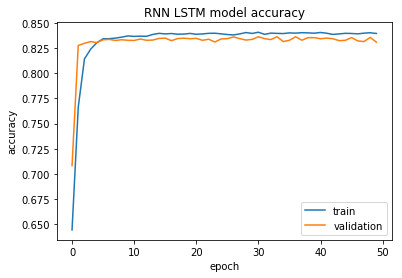

In [245]:
plt.plot(modelrnn_train.history['acc'])
plt.plot(modelrnn_train.history['val_acc'])
plt.title('RNN LSTM model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='bottom right')
plt.show()

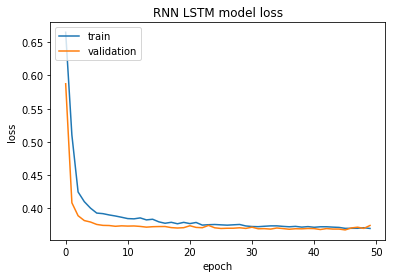

In [246]:
plt.plot(modelrnn_train.history['loss'])
plt.plot(modelrnn_train.history['val_loss'])
plt.title('RNN LSTM model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [208]:
test = pd.read_csv("data/Test_v1.txt", sep='\t', header=None, names = ["test_sen", "sarcasm_flag", "tweet"])
test = test.drop(["test_sen"],axis=1)
test['tweet'] = test['tweet'].apply(tweet_cleanup_urls_hashtags)
test['tweet'] = test['tweet'].str.lower()
test['tweet'] = test['tweet'].map(lambda x: strip_punctuation(x))
test.head()

,sarcasm_flag,tweet
0,1,i loovee when people text back 😒
1,1,dont you love it when your parents are pissed ...
2,1,so many useless classes great to be student
3,1,oh how i love getting home from work at 3am an...
4,1,i just love having grungy ass hair 😑


In [247]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
print("\nTest Accuracy: %.2f%%" % (accuracy*100))

8351/8351 [==============================] - 4s 464us/step

Test Accuracy: 83.83%
